In [1]:
import numpy as np
import scipy as sp
import math
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from data_PINN import diffeq, create_trainig_test_set

import torch.nn.functional as F

In [2]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
    print(device)

Notation:

- $\frac{k}{m} = \omega_0^2$
- $b = 2\zeta \omega_0 m$

In [3]:
#k/m = omega_0^2

#X = [x, dx/dt]
def Dx(t, X, m, b, k):
    return X[1] 

#second differential
def DDx(t, X, m, b, k):
    Dx_t = Dx(t, X, m, b, k)
    return -(1/m) * (b*Dx_t + k*X[0])

def odes(t, X, m, b, k):
    DDx_t = DDx(t, X, m, b, k)
    Dx_t = Dx(t, X, m, b, k)

    return [Dx_t, DDx_t]

def f(t, X, m, b, k):
    DDx_t = DDx(t, X, m, b, k)
    Dx_t = Dx(t, X, m, b, k)

    return m*DDx_t + b*Dx_t + k*X[0]

In [ ]:
#diffeq(which ODE, number of variables, number of arguments)
damped_osc = diffeq(odes, 2, 3)

#create_trainig_test_set(which differential equation, t_span, number of timesteps, number of data (test and training)(1000 different cases, initial conditions with each 100 timepoints in it), fraction used to test model, numerical method, random seed to create data)
train, test = create_trainig_test_set(damped_osc, (0, 10), 100, 1000, 0.3, "RK45", seed=0)

In [5]:
print(train["X"].shape)
print(train["y_tensor"][0:, 0:, 0].unsqueeze(-1).shape)
print(train["t_tensor"].shape)
print(train["args_tensor"].shape)

torch.Size([700, 100, 6])
torch.Size([700, 100, 1])
torch.Size([700, 100])
torch.Size([700, 3])


In [43]:
class DampedModel(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(in_features=n_in, out_features=32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.tanh(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = DampedModel(6)

In [52]:
def loss_PINN(y_pred, y_exp, x_00, x_01, t, m, b, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True)

    m_f = m.unsqueeze(-1)
    b_f = b.unsqueeze(-1)
    k_f = k.unsqueeze(-1)
    x_00_f = x_00.unsqueeze(-1)
    x_01_f = x_01.unsqueeze(-1)

    X_f = torch.cat([m_f, b_f, k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = m_f*x_tt + b_f*x_t + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [53]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [54]:
epochs = 10000

for epoch in range(epochs):
    X = train["X"]
    y_exp = train["y_tensor"][0:, 0:, 0]
    y_pred = model(X).squeeze(-1)
    t = X[0:, 0:, 5]
    m = X[0:, 0:, 0]
    b = X[0:, 0:, 1]
    k = X[0:, 0:, 2]
    x_00 = X[0:, 0:, 3]
    x_01 = X[0:, 0:, 4]

    loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, m, b, k, N_f=100)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 1000/10000, Loss: 0.0174
Epoch 2000/10000, Loss: 0.0126
Epoch 3000/10000, Loss: 0.0151
Epoch 4000/10000, Loss: 0.0091
Epoch 5000/10000, Loss: 0.0088
Epoch 6000/10000, Loss: 0.0080
Epoch 7000/10000, Loss: 0.0077
Epoch 8000/10000, Loss: 0.0075
Epoch 9000/10000, Loss: 0.0072
Epoch 10000/10000, Loss: 0.0074


In [55]:
model.eval()
with torch.no_grad():
    T_pred_test = model(test["X"])
    #print(T_pred_test)
    test_loss = loss_func(T_pred_test, test["y_tensor"][0:, 0:, 0].unsqueeze(-1))
    print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0065


torch.Size([300, 100, 1])


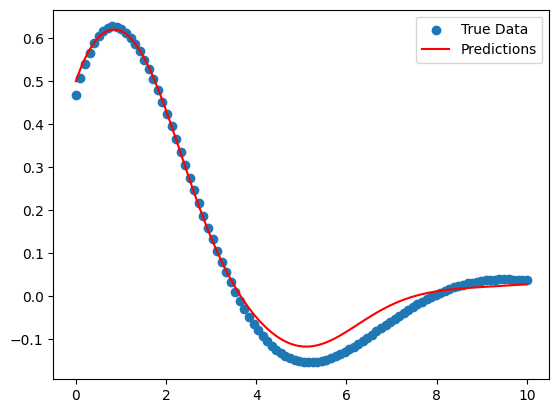

In [63]:
print(T_pred_test.shape)

n = 60
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], T_pred_test[n], color="red", label="Predictions")
plt.legend()
plt.show()